# Understanding Racial Bias in Prison Sentence Data

Using a representative dataset, we will discuss how racial bias can be understood quantitatively.  To do this, we will use a classic and robustly optimized supervised machine learning approach to generate a predictive model for prison sentences bassed on a number of features, including race.  We can then see how there are disparities between prison sentences given that all other features are equal *except* for race.  This model is then wrapped into a server framework where predictions can be made and understood.  It is hoped that we can provide a way for nontechnical users to better estimate fair prison sentences for all races represented in the model. 

## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
import dython

import pickle
import datetime as dt
import sys
import os
import inspect
import json

from predict import clean_data  #local functions are identical to those which are used in the flask server

modelDirectory = "../server/models/"  #path to input data and trained models.



Bad key "text.kerning_factor" on line 4 in
/Users/nilmeier@us.ibm.com/anaconda2/envs/p37-dojo/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Loading the Training Data

The dataset used is provided by Cook County, IL, the county which houses Chicago, and among the most populous cities in the United States.  Like most large cities, there is significant ethnic and socioeconomic diversity, with extremes in wealth and poverty.  Cook County has released a trove of criminal and other data through their Open Data program.  We will study and model the data from the following source:

**Data Source**: https://datacatalog.cookcountyil.gov/Courts/Sentencing/tg8v-tm6u/data 

**Data Dictionary**: https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf  

**Data description**: https://www.cookcountystatesattorney.org/resources/how-read-data

In [2]:
# Downloading Cook County Dataset
if os.path.isfile(modelDirectory + 'Sentencing-cook_county.csv'):
    print("Cook County Data Already Downloaded")
else:
    !wget -O ../server/models/Sentencing-cook_county.csv https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/rows.csv?accessType=DOWNLOAD 

--2020-10-15 04:56:55--  https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/rows.csv?accessType=DOWNLOAD
Resolving datacatalog.cookcountyil.gov (datacatalog.cookcountyil.gov)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to datacatalog.cookcountyil.gov (datacatalog.cookcountyil.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘../server/models/Sentencing-cook_county.csv’

../server/models/Se     [        <=>         ] 117.36M  9.57MB/s    in 12s     

2020-10-15 04:57:07 (9.69 MB/s) - ‘../server/models/Sentencing-cook_county.csv’ saved [123066339]



The data has 41 columns, and many of those columns are not useful in any type of training strategy, so we will load only the following columns:

In [3]:
csv = modelDirectory + 'Sentencing-cook_county.csv'
#csv = 'https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/rows.csv'
cols = ['CHARGE_COUNT',
        'CHARGE_DISPOSITION', 'UPDATED_OFFENSE_CATEGORY', 'PRIMARY_CHARGE_FLAG',
        'DISPOSITION_CHARGED_OFFENSE_TITLE', 'DISPOSITION_CHARGED_CLASS', 'SENTENCE_JUDGE',
        'SENTENCE_PHASE', 'COMMITMENT_TERM', 'COMMITMENT_UNIT', 'LENGTH_OF_CASE_in_Days',
        'AGE_AT_INCIDENT', 'RACE', 'GENDER', 'INCIDENT_CITY', 'LAW_ENFORCEMENT_AGENCY',
        'LAW_ENFORCEMENT_UNIT', 'SENTENCE_TYPE']
# 'CASE_PARTICIPANT_ID' and 'ARREST_DATE' could be useful if matched with another 
# dataset for including criminal history information
orig_data = pd.read_csv(csv, usecols=cols)
data = orig_data.copy()

/Users/nilmeier@us.ibm.com/anaconda2/envs/p37-dojo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploring the data

An important part of any Data Science approach is to explore the data.  It is important not only for the Data Scientist modeling the data, but for people new to the problem who are trying to develop a deeper understanding of the model.  Exploratory studies reveal the thinking of the data scientist in developing the model, and also provide nice code examples that point to ways of extracting and summarizing the data in meaningful ways.

## Exploring the Distribution of Categories in High Cardinality Variables

An important thing to understand about this categorical data is that there are a very large number of categories in many columns, but that there are also a much smaller set of categories that are reported with significant frequency.  Let's take a look at the function written to count these:

In [4]:
# check categorical distribution
def check_cat_dist(data, col_name, thresh=.1, top_n=25):
    '''fraction of data in levels that represent less than 10% of total'''
    freqs = data[col_name].value_counts()
    
    # percent of data represented by categories with x members
    frac_by_freq = freqs.groupby(freqs).sum()/data.shape[0] 
    thresh = data.shape[0]*thresh
    mask = frac_by_freq.index < thresh
    
     # percent of data in categories that each represent less than 10% of all obs
    frac_below_thresh = frac_by_freq[mask].sum()
    
    # number of categories which have more than thresh % (e.g. 10%) of data in them
    num_above_thresh = (~mask).sum() 
    frac_top_n = freqs[:top_n].sum()/data.shape[0]
    return frac_below_thresh, num_above_thresh, frac_top_n

Now we can generate a "spot check" for each of the features:           

In [5]:
# look at distribution of obs across categories
thresh = .05
top_n=73
for i in data.select_dtypes('object').columns:
    print(i)
    a,b,c = check_cat_dist(data, i, thresh, top_n)
    print(f'{data[i].unique().shape[0]} categories')
    print(f'{round(a*100,3)}% of categories have less than {thresh*100}% of the data in them')
    print(f'{b} categories have more than {thresh*100}% of the data in them')
    print(f'{round(c*100,3)}% of the data is in the most frequent {top_n} categories', '\n')


# future: turn into transformer with thresh and top_n as params (is that already in OneHotEncoder?)

DISPOSITION_CHARGED_OFFENSE_TITLE
1649 categories
72.795% of categories have less than 5.0% of the data in them
3 categories have more than 5.0% of the data in them
89.093% of the data is in the most frequent 73 categories 

DISPOSITION_CHARGED_CLASS
14 categories
1.563% of categories have less than 5.0% of the data in them
6 categories have more than 5.0% of the data in them
99.992% of the data is in the most frequent 73 categories 

CHARGE_DISPOSITION
28 categories
2.624% of categories have less than 5.0% of the data in them
2 categories have more than 5.0% of the data in them
100.0% of the data is in the most frequent 73 categories 

SENTENCE_JUDGE
331 categories
99.695% of categories have less than 5.0% of the data in them
0 categories have more than 5.0% of the data in them
87.724% of the data is in the most frequent 73 categories 

SENTENCE_PHASE
6 categories
4.372% of categories have less than 5.0% of the data in them
1 categories have more than 5.0% of the data in them
100.0% o

We can see that, for DISPOSITION_CHARGED_OFFENSE_TITLE, there are many categories, but the top 70 or so categories are used much more than the remainder of the dataset.  73% of the categories are virtually empty, (contain <5% of the data).  Looking at the data, there are lots of low counts at the bottom of the list...

In [6]:
data['DISPOSITION_CHARGED_OFFENSE_TITLE'].value_counts()

POSSESSION OF A CONTROLLED SUBSTANCE                                                                              37210
AGGRAVATED DRIVING UNDER THE INFLUENCE OF ALCOHOL                                                                 15319
RETAIL THEFT                                                                                                      13581
FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT, OR PRIVILEGE TO OPERATE A MOTOR VEHICLE IS SUSPENDED OR REVOKED    10824
AGGRAVATED UNLAWFUL USE OF WEAPON                                                                                 10098
                                                                                                                  ...  
UNLAWFUL USE OF A SCANNING DEVICE                                                                                     1
KNOW DAMAGE PROP>$10K-100K                                                                                            1
POSSESS CANNABIS 2000-5000 GRAMS        

DISPOSITION_CHARGED_CLASS has fewer categories, and most of them have many counts.

In [7]:
data['DISPOSITION_CHARGED_CLASS'].value_counts()

4    98827
2    49710
3    37328
1    23500
A    16334
X    13490
M     2672
B      616
C      401
Z       67
O       21
P       18
U        3
Name: DISPOSITION_CHARGED_CLASS, dtype: int64

## Cleaning The Data

The data needs to be cleaned...this involves filtering out data rows for which no prison sentence is assigned, and removing columns not used in the model.  You can review the `clean_data` function in `predict.py`.

In [8]:
# This function remove null values, standardizes spellings of categories, and 
data = clean_data(orig_data, removeColumns=True)

### JSON Schema of cleaned data

Each record can be converted to a JSON string using the following syntax:

In [9]:
# JSON of first example
json_str = orig_data.iloc[0].to_json()
print(json.dumps(json.loads(json_str), indent=2))

{
  "PRIMARY_CHARGE_FLAG": false,
  "DISPOSITION_CHARGED_OFFENSE_TITLE": "FIRST DEGREE MURDER",
  "CHARGE_COUNT": 2,
  "DISPOSITION_CHARGED_CLASS": "X",
  "CHARGE_DISPOSITION": "Nolle On Remand",
  "SENTENCE_JUDGE": "John  Mannion",
  "SENTENCE_PHASE": "Original Sentencing",
  "SENTENCE_TYPE": "Conversion",
  "COMMITMENT_TERM": null,
  "COMMITMENT_UNIT": null,
  "LENGTH_OF_CASE_in_Days": 619.0,
  "AGE_AT_INCIDENT": 27.0,
  "RACE": "Black",
  "GENDER": "Male",
  "INCIDENT_CITY": null,
  "LAW_ENFORCEMENT_AGENCY": "CHICAGO POLICE DEPT",
  "LAW_ENFORCEMENT_UNIT": null,
  "UPDATED_OFFENSE_CATEGORY": "Homicide"
}


You can also get the schema of the dataset:

In [10]:
# get data types for each variable
orig_data_dtypes = ['str' if str(i) is 'object' else str(i) for i in orig_data[cols].dtypes]
dict(zip(cols, orig_data_dtypes))

{'CHARGE_COUNT': 'int64',
 'CHARGE_DISPOSITION': 'str',
 'UPDATED_OFFENSE_CATEGORY': 'str',
 'PRIMARY_CHARGE_FLAG': 'bool',
 'DISPOSITION_CHARGED_OFFENSE_TITLE': 'str',
 'DISPOSITION_CHARGED_CLASS': 'str',
 'SENTENCE_JUDGE': 'str',
 'SENTENCE_PHASE': 'str',
 'COMMITMENT_TERM': 'str',
 'COMMITMENT_UNIT': 'str',
 'LENGTH_OF_CASE_in_Days': 'float64',
 'AGE_AT_INCIDENT': 'float64',
 'RACE': 'str',
 'GENDER': 'str',
 'INCIDENT_CITY': 'str',
 'LAW_ENFORCEMENT_AGENCY': 'str',
 'LAW_ENFORCEMENT_UNIT': 'str',
 'SENTENCE_TYPE': 'str'}

## Building the Sentence Length Model

This model forms a classic supervised learning model, with the prison sentence length (COMMITMENT_TERM) as the predicted variable.  More specifically, it is a **regression**, since the predicted variable is a floating point number.

### Preparing the Data

In [11]:
# train test split

# the target variable (label) is the value to be predicted
target = 'COMMITMENT_TERM'

# the label column is removed, leaving only features for x
x_data = data.drop(target,axis=1)
# and the target defined as the y value
y_data = data[target]

rng = np.random.RandomState()
rs = rng.get_state()

# Training and test datasets are generated from the cleaned source data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=rng)

## Building the Prediction Pipeline

A Prediction Pipeline usually consists of transformations upstream from a model, followed by the model to be fit.  It is a convenient way to group the standardized operations associated with model building.

Categorical Features are almost always transformed into the one hot encoding representation.

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore')
categorical_feats = ('cats', ohe, x_data.select_dtypes('object').columns)
feat_trans = ColumnTransformer([categorical_feats], remainder='passthrough')

The Model is the `XGBRegresssor`, a gradient boosting algorithm that is known to provide very good prediction performance relative to other algorithms.

In [13]:
model = XGBRegressor()

The pipeline is then easily constructed from the components:

In [14]:
feat_transform = ('ct', feat_trans)
sentence_model = ('xgb', model)
sentence_pipe = Pipeline([feat_transform, sentence_model])

## Model Training and Hyperparameter Optimization

Every model has two types of parameters:
   
1) **Parameters** that are optimized, and completely determined by the optimization protocol and dataset.

2) **Hyperparameters** - These parameters are important in the definition of the model, but are not subject to any automatic adjustment.
            
The discovery of optimal hyperparameters often involves interaction between the data scientist and the algorithm, with lots of manual adjustment and application of intuition.  Sometimes, the optimal set of hyperparameters can be easily discovered, while other times it makes more sense to do a systematic and orderly search of hyperparameter combinations.  Fortunately, we have hyperparameter libraries to assist us in this endeavor!

In [15]:
from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper
from skopt.space import Real, Categorical, Integer

Here, we're going to define some of the hyperparameters to search.  For tree based methods, there are lots of hyperparameters!  

In [16]:
# fit HPO
# define hyperparameter search space
search_space = {} 
search_space['xgb__n_estimators'] = Integer(40, 600)
search_space['xgb__max_depth'] = Integer(3, 10)
search_space['xgb__min_child_weight'] = Integer(1,12) 
search_space['xgb__gamma'] = (0., 500.) # thinking about scale of MSE
search_space['xgb__subsample'] = (.5, 1)
search_space['xgb__colsample_bytree'] = (.5, 1)
search_space['xgb__reg_lambda'] = (1e-6, 1e6, "log-uniform")
search_space['xgb__reg_alpha'] = (1e-5, 1e1, "log-uniform")
search_space['xgb__learning_rate'] = (.05, .3)
search_space

{'xgb__n_estimators': Integer(low=40, high=600, prior='uniform', transform='identity'),
 'xgb__max_depth': Integer(low=3, high=10, prior='uniform', transform='identity'),
 'xgb__min_child_weight': Integer(low=1, high=12, prior='uniform', transform='identity'),
 'xgb__gamma': (0.0, 500.0),
 'xgb__subsample': (0.5, 1),
 'xgb__colsample_bytree': (0.5, 1),
 'xgb__reg_lambda': (1e-06, 1000000.0, 'log-uniform'),
 'xgb__reg_alpha': (1e-05, 10.0, 'log-uniform'),
 'xgb__learning_rate': (0.05, 0.3)}

The full search of hyperparameter space can take over 30 min on a typical laptop, so we have provided a pretrained model.  If you want to train your own, set `TRAIN=True`

In [17]:
# Train a new model or use existing saved model
TRAIN = False # True #

In [18]:
# fit model / search for optimal HPs for optimal model config
#earlystop = DeltaYStopper(delta=.5,n_best=7)
if TRAIN:
    hpo = BayesSearchCV(sentence_pipe,
                        search_space,
                        cv=4,
                        scoring = 'neg_mean_squared_error', 
                        iid=False,
                        n_jobs = -1,
                        n_iter = 100,
                        verbose = 2,
                        n_points=6
                        ) 
    %time hpo.fit(x_train, y_train)#, callback=earlystop) # 31 mins

Here we load the full set of Hyperparameter searches

In [19]:
if not TRAIN:
    HPO_PATH = modelDirectory + 'bayesHPO_mae1.555.pkl'
    with open(HPO_PATH, 'rb') as f:
        hpo = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../server/models/bayesHPO_mae1.555.pkl'

We'll pick the best model of the group and use that one for our predictions.  Let's look at the hyperparameter combo that gave the best model:

In [ ]:
# Access prediction pipeline with optimal hyperparameters
sentence_pipe = hpo.best_estimator_ 
val_score = hpo.best_score_
display(hpo.best_params_)
preds = sentence_pipe.predict(x_test)
test_score = hpo.scorer_._score_func(y_test, preds)
print('MSE:',test_score)

Some of the parameters might have been intuitive, like the depth of the tree, for example, being at the higher setting.  But others are not entirely intuitive, and a systematic search really is much better, even if it does take much longer.

## Evaluate Accuracy and Serialize Model

Typical fitness measures for regression are reported here (Mean Absolute Error and Correlation Coefficient)

In [ ]:
# evaluate accuracy
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print('Mean Absolute Error:',mae)
print('Fraction of total target variance accounted for (r^2):', r2)

## Saving Model as a `pkl` file

In [ ]:
# pickle sentence length pipeline obj
if TRAIN:
    PIPE = sentence_pipe
    ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
    name_pipe = f'../saved_models/sentence_pipe_mae{round(mae,3)}_{ts}'
    with open(name_pipe+'.pkl', 'wb') as f:
        pickle.dump(PIPE, f, -1)

In [ ]:
# pickle HPO obj
if TRAIN:
    HPO = hpo
    #ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
    #name=name_pipe.replace('sentence_pipe', 'bayesHPO')
    name = f'../saved_models/bayesHPO_mae{round(mae,3)}'
    with open(name+'.pkl', 'wb') as f:
        pickle.dump(HPO, f, -1)

In [ ]:
res = hpo.optimizer_results_[0]

In [ ]:
Hyperparameters and their Impact on Model Performance. 

The following plot shows the importance of various hyperparameters on model performance.  The objective function is the function that is optimized, so it is naturally highly correlated (and in fact not a hyperparameter).  The most correlated paraemter is $\lambda$, the regularization parameter.  Note that there is a "sweet spot" for $\lambda$, as it is neither close to the minimum or maximum value.

In [ ]:
df = pd.DataFrame(res['x_iters'],columns=[i for i in hpo.best_params_])
df = df.assign(objective=res['func_vals'])
sns.heatmap(df.corr().loc[: ,['objective']],annot=True, center=0)
plt.title('Correlations of Hyperparameters to Model Performace')

## Evaluate Error Distribution and Plots

A quick summary plot of values and predictions can give us an idea as to how the model is performing over the range of predicted values.

In [ ]:
# distribution of target and predictions in test set 
plt.hist(y_test, bins=40, alpha=.3, label='Actual')
plt.hist(preds, bins=40, alpha=.3, label='Predicted')
plt.legend()
plt.show()

In [ ]:
error = y_test - preds

A quick look at the distribution of errors reveals that the errors in predictions seem to be more around African Americans.  In fact, there are just many more African Americans in the dataset, and the error seems to be distributed symmetrically and about the prediction.  

In [ ]:
factor = 'RACE' # 'DISPOSITION_CHARGED_CLASS' #  
sns.scatterplot(preds, error, alpha=.5, hue=x_test[factor].values)
plt.axhline(0, ls='--', c='orange')
plt.title('Predictions vs Error')
plt.xlabel('Predicted Values')
plt.ylabel('Error')
plt.show()

In [ ]:
print('Race Distribution in Test Data')
x_test.groupby('RACE').size()/x_test.shape[0]

We see here that the 74% of the people in the dataset are African American.

In [ ]:
plt.scatter(x_test['RACE'], error)
plt.title('Error Distributions by Race')
plt.ylim([60,-60])
# there are are some BIG outliers (90 years off the correct prediction....)

Errors for Black people are larger, however they are the largest share of 
the sample.  

Are the larger errors for black people a natural result of their over representation in the data? or does it mean I am missing distinguishing features among black people?

## Building a Racial discrepancy evaluator

Using the theoretical approach of https://github.com/IBM/causallib/blob/master/examples/standardization.ipynb
which follows https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/

We're going to introduce the notion of a counterfactual race, which simply means that we will take a person, or feature list, and holding all other fetures constant, will take the counter of the race.  A map of "opposite" races is listed below.

In [89]:
from predict import make_counterfactual
print(inspect.getsource(make_counterfactual))

def make_counterfactual(data):
    '''Take data and switch race variable to "opposite" value'''
    # white --> black
    # non-white --> white
    race_counterfactual_map = \
        {'Black': 'White',
         'White': 'Black',
         'HISPANIC': 'White',
         'Asian': 'White',
         'American Indian': 'White'}

    data_counterfactual = data.copy()
    data_counterfactual['RACE'] = data['RACE'].map(race_counterfactual_map)
    return data_counterfactual



The discrepancy estimate then, is simply the difference between the predicted sentence of a person of a given race (based on historical data), and the predicted sentence of a person with *only the race* modified to a counterfactual state. 

In [90]:
# display discrepancy calculation code
from predict import estimate_discrepancy
print(inspect.getsource(estimate_discrepancy))

def estimate_discrepancy(model, data, return_pred=False):
    '''
    Estimate discrepancy in sentence length if race were switched.
    
    The discrepancy estimate represents # of additional years to which the
    actual profile would be sentenced over the counterfactual profile. A 
    positive discrepancy means that the actual race would recieve a 
    harsher sentence than the counterfactual race.

    Params:
        return_pred: (bool) if True, returns a tuple of 
            (descrepancy, prediction), otherwise just returns descrepancy

    Returns:
        discrepancy is a 1-d numpy array
    '''
    pred = model.predict(data)
    diff = pred - model.predict(make_counterfactual(data))
    if return_pred:
        return diff, pred

    return diff



This is an important number, and the one which we use to quantify what is termed racial bias in prison sentencing.  Let's save these numbers in our data folder

In [175]:
rng.set_state(rs) # reset random state for replicable split
x_train, x_test = train_test_split(x_data, random_state=rng)

In [176]:
import json

In [177]:
discrepancy = estimate_discrepancy(sentence_pipe, x_test)
discrepancy_s = pd.Series(discrepancy)

In [178]:
# calculate as percent of (estimated?) sentence
percent_discrepancy = (discrepancy/y_test) * 100
#percent_discrepancy = (discrepancy/preds) * 100

In [179]:
# drop cases where sentence lenght is 0 for now
mask = (y_test == 0)
discrepancy = discrepancy[~mask.values]
percent_discrepancy = percent_discrepancy[~mask.values]

In [188]:
# save list of test discrepancies, to evaluate percentile discrepancy in runtime data
if TRAIN:
    # include some indicator of how/where the train/test split was made?
    with open(dataDir + 'test_data_percentage_discrepancies.json', 'w') as f:
        json.dump(percent_discrepancy.tolist(), f)

## Exploring Racial Discrepancies in Sentencing

In [189]:
# SOME HUGE outliers in percent discrepancy
percent_discrepancy_s = pd.Series(percent_discrepancy)
percent_discrepancy_s.groupby(x_test['RACE']).describe()

#

,count,mean,std,min,25%,50%,75%,max
RACE,,,,,,,,
American Indian,12.0,3.371895,22.079713,-54.632282,-1.314514,6.662697,15.625513,34.002511
Asian,112.0,-10.870258,22.970013,-172.037179,-18.407279,-5.740355,1.049657,31.741822
Black,23009.0,3.748394,120.177733,-10108.253002,-0.000584,4.387558,11.124182,7303.034484
HISPANIC,4601.0,-4.262972,20.071296,-355.931854,-6.131738,-0.912074,2.391362,144.117856
White,3245.0,-7.243690,20.725349,-384.080315,-9.855700,-3.649616,0.786293,84.757757


 This appears to be a case where the 50th% percentile (i.e. median) is more informative than the mean (bc of the outliers)

We can say that, most of the time, black people are treated btw 2% less harshly and 16% more harshly than white people and white people are treated btw 14% less harshly and 4% more harshly than black people.

[Text(0.5, 1.0, 'Average Percent Racial Sentencing Discrepancy by Race')]

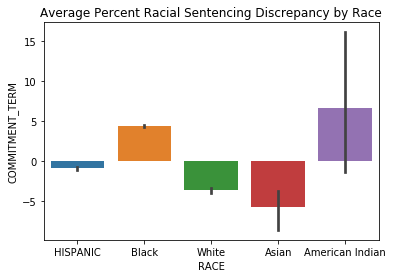

In [190]:
# distribution of positive discrepancies
percent_discrepancy_by_race = percent_discrepancy_s.groupby(x_test['RACE']).mean()
ax = sns.barplot(x=x_test['RACE'], y=percent_discrepancy_s, estimator=np.median)
ax.set(title='Average Percent Racial Sentencing Discrepancy by Race')

# result: interesting that hispanic appears to be sentenced less harshly than white

Text(0.5, 1.0, 'Distribution of Racial Discrepancies by Race')

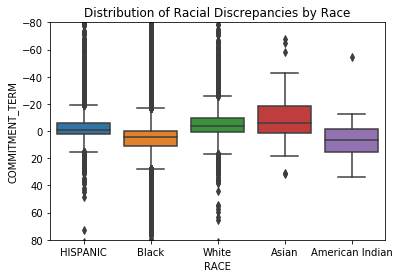

In [191]:
sns.boxplot(x=x_test['RACE'], y=percent_discrepancy_s)
plt.ylim([80, -80])
plt.title('Distribution of Racial Discrepancies by Race')

## Feature Importance with respect to Sentence Length

In [100]:
import re

In [106]:
# per level on categoricals

# subclass the ColumnTransformer instead?
def get_feature_names(ohe_name, column_transformer, delim='_*_'):
    '''
    Get feature names that include factor names, from a ColumnTransformer 
    containing a onehot encoder. Builtin get_feature_names() 
    method  (ver 0.23) only includes factor column index. 

    Params:
        ohe_name: (str) name of OneHotEncoder obj in .transformers_ of ColumnTransformer
    '''
    cols = column_transformer.get_feature_names()
    
    
    
    # col index for onehot encoder named 'cats'
    cats_cols = {i[0]:i[2] for i in column_transformer.transformers_}['cats']
    # replace x0, x1, etx with original col names
    cats_idx = [re.findall(ohe_name + r'__x(\d)_', label) for label in cols]
    fixed_cols = [re.sub(ohe_name + r'__(x\d)_', cats_cols[int(cat_i[0])]+delim, cols[i]) if cat_i else cols[i] for i, cat_i in enumerate(cats_idx)] 
    # Alt:
    #cats_level_cols = column_transformer.named_transformers_[ohe_name].get_feature_names(input_features=cats_cols)
    #cats_idx = [i for i, c in enumerate(cols) if c.startswith(ohe_name + r'__')]
    #fixed_cols=cols.copy()
    #for i, cats_i in enumerate(cats_idx):
    #    fixed_cols[cats_i] = cats_level_cols[i]

    return fixed_cols


col_names = get_feature_names('cats', sentence_pipe['ct'])

In [108]:
## Get normalized feature imp dict and series

bst = sentence_pipe['xgb'].get_booster() # name changed to 'xgb' in retrain
# remove brackets in col names bc they break xgb feature importance code
col_names_clean =  [re.sub(r'[\[\]]', '\~', i) for i in col_names]
default_feat_names = bst.feature_names.copy()

importance_type = 'gain' # 'weight' # 'total_gain' #  
bst.feature_names = col_names_clean 
feat_imps_d = bst.get_score(importance_type=importance_type)
# reset feature names bc defaults to validate_features=True in sklearn xgb api for .predict() 
# but doesn't allow for feature names for newdate to be set during predit() 
bst.feature_names=default_feat_names
# add in zero importance features
feat_imps_d = {n:feat_imps_d.get(n, 0) for n in col_names_clean}
# make feat imps sum to 1000
total = sum(feat_imps_d.values())
feat_imps_d_norm = {k:round((v/total)*1000,3) for k,v in feat_imps_d.items()} 
feat_imps_s = pd.Series(feat_imps_d_norm).sort_values()[::-1]

Here we generate a plot of of the importance of each feature in determining sentence length:

Text(0.5, 1.0, 'Feature importance at the Category Level (top 20)')

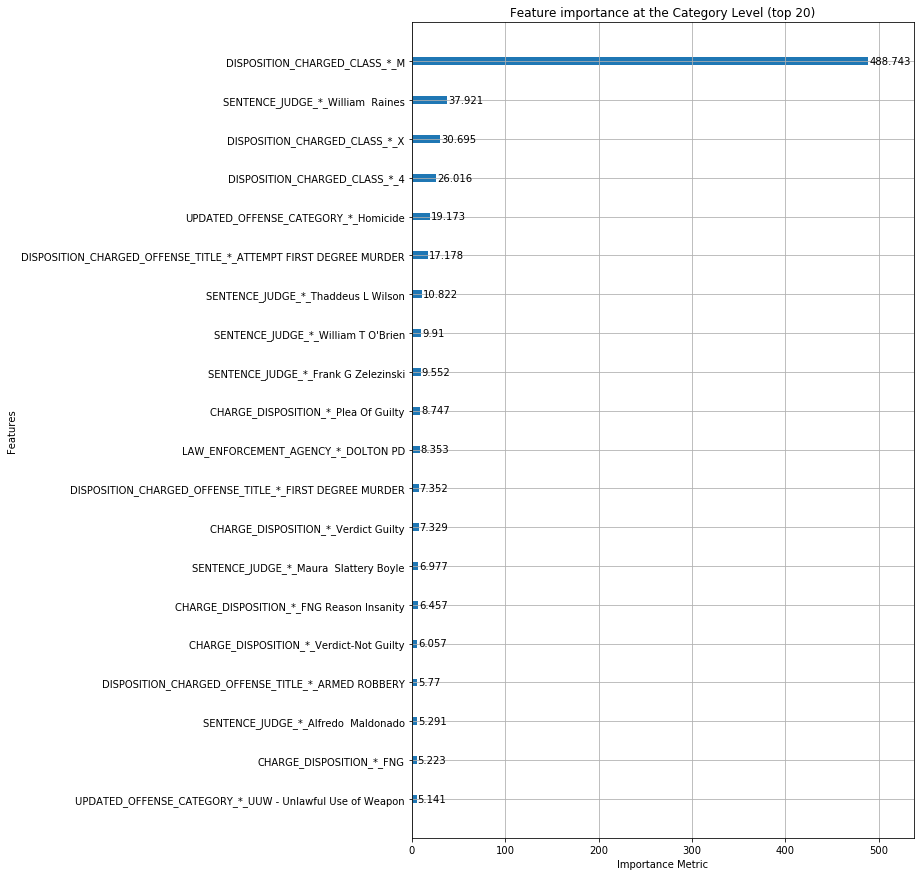

In [109]:
# highly informative:
# * Primary charge flag is highly influential... should I remove non-primary charges... 
# because the sentence won't be "primarilly" driven by that? # EXPLORE check that primary flag 
# is associated with longer sentences?
# * being black is a discriminative feature, so are several serious crimes, as well as how you got to be convicted.
# * gain vs wt or total gain brings in MALE and several judges names... but drops race...
# * 'gain' also shows that age at incident and charge count are only there because they are high cardinality

# * Class M (first degree murder) and the highest felony class are predictive, interestingly the lowest class of 
# felony is also predictive, maybe because it is a discontinuity in sentencing from the most severe misdemeanor.
#* and it will be interesting to see the distributions of the judges and police departments


# do EDA on distributions of target on Nolle prosecution, and mental health

# charge count is almost certainly inflated because it is a contiuous variable

# do EDA on the shape of the relationship between target and influential vars
 
xgb.plot_importance(feat_imps_d_norm, max_num_features=20,
                xlabel='Importance Metric',
                   )
plt.gcf().set_size_inches(9,15)
plt.title('Feature importance at the Category Level (top 20)')

In [110]:
from sklearn.inspection import permutation_importance

In [111]:
%%time
res=permutation_importance(sentence_pipe, x_test, y_test, scoring='neg_mean_squared_error', n_jobs=-1)

CPU times: user 3.58 s, sys: 414 ms, total: 4 s
Wall time: 1min 21s


While the plot above is beginning to home in on our questions, it focuses on the importance of features at particular values.  Here we will study each feature and its importance in determining sentence length.

CPU times: user 45.2 ms, sys: 4.54 ms, total: 49.7 ms
Wall time: 48.5 ms


Text(0.5, 1.0, 'Feature Importance at the Variable Level')

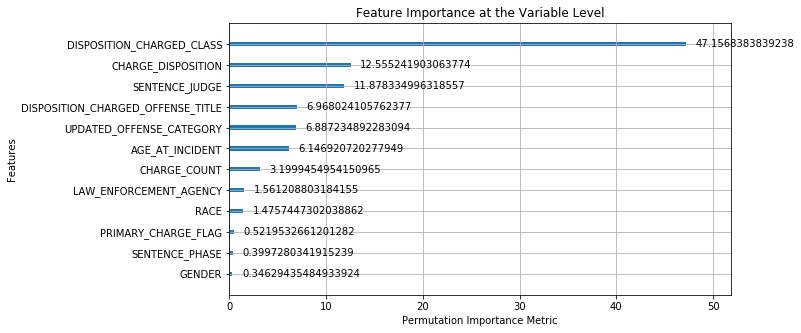

In [112]:
%%time
perm_factor_imps = dict(zip(x_train.columns, res.importances_mean))
xgb.plot_importance(perm_factor_imps,
                xlabel='Permutation Importance Metric'
                   )
plt.gcf().set_size_inches(9,5)
plt.title('Feature Importance at the Variable Level')

# We can see the order is pretty significantly different than the aggregation above, 
# particularly, Charge_Coun (one of the two continuous features) is second above when 
# it is below 50th% in the permutation imp

Race undoubtedly plays a role in determining sentence length, but other more prominent descriptors are still stronger determinants.  This is not to say that profound differences don't exist between sentences when *all other features are equal*.  This is the disparity calculation as discussed previously.

## Looking at Correlations Between Features
Highly correlated features will have deflated feature importances. It is both interesting to know what features are correlated, as well as important to context for reading the feature importances.

In [113]:
from sklearn.feature_selection import f_classif, f_regression, chi2
from scipy.stats import pearsonr, chi2_contingency
import itertools
import statsmodels.api as sm
from dython.nominal import cramers_v, correlation_ratio


We actually have some nontrivial analyses that need to be considered when looking at all of this categorical data.

**2 kinds of features**: numeric and categorical  
**3 kinds of relations**: numeric-numeric, numeric-categorical, categorical-categorical  
**3 kinds of measures of association**: Pearson r Correlation, Corrlelation Ratio, Cramer's V  
Reference: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [114]:
def dtype_mapper(key):
    key = str(key)
    if key=='object':return 'cat'
    elif key=='bool': return 'cat'
    elif key.startswith('int'): return 'num'
    elif key.startswith('float'): return 'num'
    else:
        raise ValueError(f'unanticipated type: {key}')
        
def split_dtypes(df):
    by_type = df.dtypes.map(dtype_mapper)
    cols_by_type = by_type.groupby(by_type).apply(lambda s: s.index.to_list()).to_dict()
    return cols_by_type


In [115]:
split_dtypes(data)

{'cat': ['PRIMARY_CHARGE_FLAG',
  'DISPOSITION_CHARGED_OFFENSE_TITLE',
  'DISPOSITION_CHARGED_CLASS',
  'CHARGE_DISPOSITION',
  'SENTENCE_JUDGE',
  'SENTENCE_PHASE',
  'RACE',
  'GENDER',
  'LAW_ENFORCEMENT_AGENCY',
  'UPDATED_OFFENSE_CATEGORY'],
 'num': ['CHARGE_COUNT', 'COMMITMENT_TERM', 'AGE_AT_INCIDENT']}

In [116]:
def fill_mat(rows, cols, pairs, metric):
    '''
    Utility to populate matrix cell-wise given combinations 
    of the names of variables from two lists and a pairwise metric.
    '''
    df = pd.DataFrame(index=rows, columns=cols, dtype='float')
    for i, j  in pairs:
        # data is a global var
        res = metric(data[i], data[j])
        df.loc[i, j] = res 
    return df.T # transpose for lower triangle


def get_associations(data):
    '''
    Get association matrix for each the 3 kinds of variable relations.
    '''

    cols_by_type = split_dtypes(data)

    # 'cat2cat': 
    metric = cramers_v
    rows = cols_by_type['cat']
    cols = cols_by_type['cat']
    pairs = itertools.combinations(cols, 2)
    cat2cat = fill_mat(rows, cols, pairs, metric)


    #cat2num
    metric = correlation_ratio # must take (cat var, num var) as first two args
    rows = cols_by_type['cat']
    cols = cols_by_type['num']
    pairs = itertools.product(rows, cols) 
    cat2num = fill_mat(rows, cols, pairs, metric)

    #num2num
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool)) # upper triangle is True
    num2num = corr.mask(mask, np.nan)


    dfs = {'num2num': num2num, 'cat2num': cat2num, 'cat2cat': cat2cat}

    return dfs

In [117]:
%%time
dfs = get_associations(data)

CPU times: user 8.15 s, sys: 608 ms, total: 8.76 s
Wall time: 8.81 s


In [118]:
def plot_associations(dfs):
    '''
    plot the association matrices returned by get_associations()
    '''
    for name, df in dfs.items():
        ax = sns.heatmap(df, annot=True, cmap=None, vmin=-1, vmax=1, center=0,
                    square=False, linewidths=.5, fmt='.2f')
        ax.set(title=name)
        if name == 'cat2num':
            ax.set(xlabel='Categorical Variables', ylabel='Numeric Variables')
        plt.show()

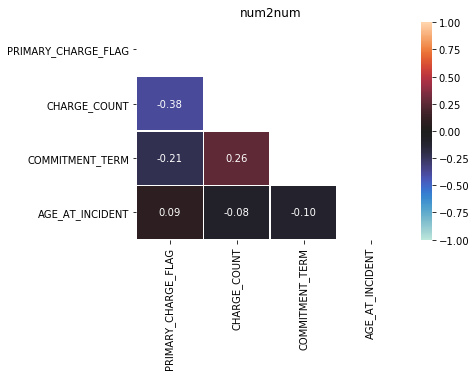

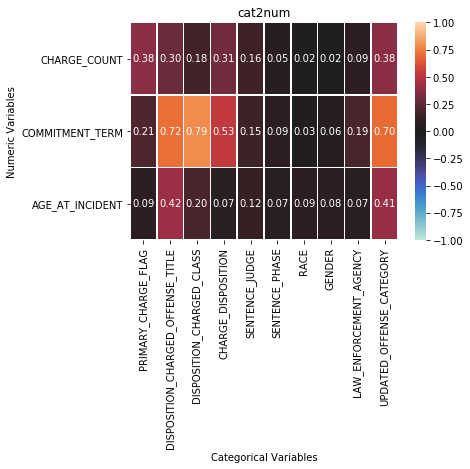

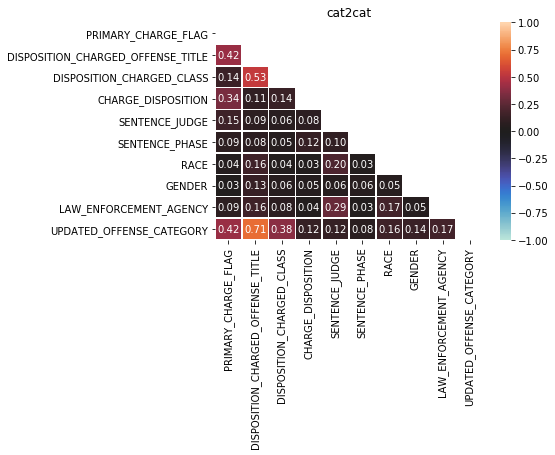

In [119]:
plot_associations(dfs)

The correlations shown reveal possible redundancies in the information that the data is providing.  For example, the DISPOSITION_CHARGED_OFFENSE and UPDATED_OFFENSE_CATEGORY are highly correlated (0.71), which suggests that these features tell much of the same story with regard to the particular person.  There are many techniques to remediate this, including orthogonalization (for numerical data), but not as much for mixed categorical and numerical sets.

## Limitations and Future Work



* Some factors that might be results of racial bias or might capture information about decisions made with racial bias are included in the model that identifies if race was influential which likely decreases the influence of the varaible race, by decreasing its ability to capture all information about racial bias on the sentence because some information about racial bias is being encoded in these other variables (like charge_count). A possible solution could be a sentitivity test to refit the model and asses the influence of race (and the decrease in model accuracy) as you exclude other variables, allowing you to pinpoint which variables are encoding the most information that could be attributed to race.
* we expect past history of convictions to play a significant role in predicting sentence length and be unqually distributed by race. We did not include this factor because limitations in data access, and this is serious limitation in the accuracy of our models. Incorporating this information will be a critical future work step.
* consider class imbalance of black versus white convicted persons
* use age at sentencing not age at incident, to better predict sentence length.

Notebook written by:
- [Noah Chasek Macfoy](https://www.linkedin.com/in/noah-chasek-macfoy) 
Data Scientist, IBM
- [Jerome Nilmeier, PhD](http://linkedin.com/in/nilmeier)
Developer Advocate and Data Scientist, IBM